In [59]:
%pip install Sastrawi

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
import nltk

In [62]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rafi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import joblib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [64]:
# Load dataset
df = pd.read_csv('smart_locker_reviews.csv', sep=";")

In [65]:
df

,review,sentiment
0,"Kualitas smart locker ini sangat buruk, sering...",Negative
1,Desain smart locker sangat modern dan menarik.,Positive
2,Smart locker ini memiliki fitur yang cukup sta...,Neutral
3,"Keamanan smart locker ini sangat tinggi, saya ...",Positive
4,Smart locker ini sering tidak bisa diakses saa...,Negative
...,...,...
1356,"Sistem sering tidak berfungsi, sangat mengecew...",Negative
1357,"Deteksi wajah sering tidak akurat, sangat tida...",Negative
1358,"Proses verifikasi sangat lambat, sangat tidak ...",Negative
1359,"RFID sering tidak terdeteksi, sangat mengganggu.",Negative


### Case Folding

In [66]:
# Ensure reviews are strings and lowercase
df['review'] = df['review'].astype(str).str.lower()

In [67]:
def clean_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

### Tokenizing

In [68]:
df['tokens'] = df['cleaned_review'].apply(word_tokenize)

### Stopword Removal

In [69]:
stop_words = set(stopwords.words('indonesian'))

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

df['tokens'] = df['tokens'].apply(remove_stopwords)

### Stemming

In [70]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_tokenizer(text):
    return [stemmer.stem(word) for word in text]

df['tokens'] = df['tokens'].apply(stem_tokenizer)
df['processed_review'] = df['tokens'].apply(lambda x: ' '.join(x))

### Pembobotan TF-IDF

In [71]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=1, ngram_range=(1, 1))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_review'])

In [72]:
# Menampilkan 10 kata dengan nilai IDF tertinggi
freqs = tfidf_matrix.sum(axis=0)
idf_values = tfidf_vectorizer.idf_
word_idf = dict(zip(tfidf_vectorizer.get_feature_names_out(), idf_values))

top_idf_words = sorted(word_idf.items(), key=lambda x: x[1], reverse=True)[:10]
for word, idf in top_idf_words:
    print(f'Kata: {word}, Kemunculan: {idf}')

Kata: adaptasi, Kemunculan: 7.523562306149512
Kata: aktif, Kemunculan: 7.523562306149512
Kata: bahan, Kemunculan: 7.523562306149512
Kata: beda, Kemunculan: 7.523562306149512
Kata: beli, Kemunculan: 7.523562306149512
Kata: benerbener, Kemunculan: 7.523562306149512
Kata: biasabiasa, Kemunculan: 7.523562306149512
Kata: buangbuang, Kemunculan: 7.523562306149512
Kata: cepet, Kemunculan: 7.523562306149512
Kata: colok, Kemunculan: 7.523562306149512


### klasifikasi SVM

In [89]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['sentiment'], test_size=0.2, random_state=42)

model = svm.SVC(C=10, kernel='rbf', gamma=1)
model.fit(tfidf_matrix, df['sentiment'])

SVC(C=10, gamma=1)

In [90]:
pred = model.predict(X_test)
pred

array(['Negative', 'Positive', 'Positive', 'Negative', 'Neutral',
       'Negative', 'Neutral', 'Neutral', 'Negative', 'Neutral',
       'Positive', 'Neutral', 'Neutral', 'Negative', 'Positive',
       'Positive', 'Negative', 'Positive', 'Negative', 'Neutral',
       'Negative', 'Neutral', 'Neutral', 'Positive', 'Positive',
       'Neutral', 'Neutral', 'Positive', 'Positive', 'Negative',
       'Neutral', 'Neutral', 'Negative', 'Negative', 'Positive',
       'Positive', 'Positive', 'Negative', 'Neutral', 'Positive',
       'Neutral', 'Positive', 'Positive', 'Positive', 'Positive',
       'Negative', 'Positive', 'Positive', 'Neutral', 'Negative',
       'Negative', 'Positive', 'Positive', 'Positive', 'Negative',
       'Neutral', 'Negative', 'Negative', 'Negative', 'Negative',
       'Neutral', 'Positive', 'Negative', 'Negative', 'Positive',
       'Neutral', 'Negative', 'Positive', 'Positive', 'Neutral',
       'Neutral', 'Positive', 'Positive', 'Negative', 'Neutral',
       'Positive'

In [91]:
print(f"Accuracy : {model.score(X_test, y_test)}")

Accuracy : 0.9853479853479854


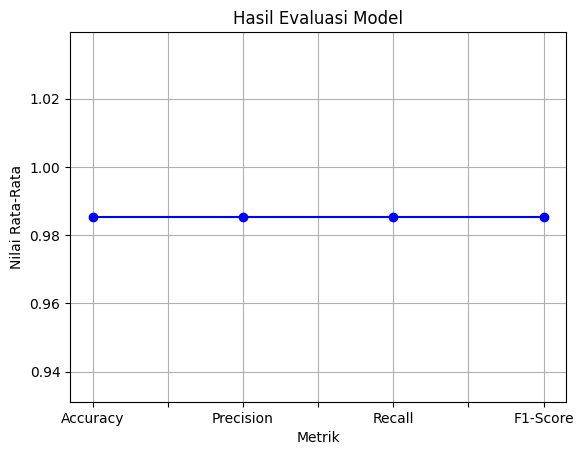

In [92]:
pred = model.predict(X_test)
acc_score = accuracy_score(y_test, pred) 
pre_score = precision_score(y_test, pred, average='weighted')
rec_score = recall_score(y_test, pred, average='weighted')
f_score = f1_score(y_test, pred, average='weighted')

scores = {
    'Accuracy': acc_score,
    'Precision': pre_score,
    'Recall': rec_score, 
    'F1-Score': f_score
}

eval_df = pd.DataFrame.from_dict(scores, orient='index', columns=['Score']) 

eval_df['Score'].plot(kind='line', marker='o', color='blue') 

plt.title('Hasil Evaluasi Model')
plt.xlabel('Metrik') 
plt.ylabel('Nilai Rata-Rata')
plt.grid(True) 

plt.show()

In [93]:
# Evaluasi pada training set
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

# Evaluasi pada testing set
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

Training Accuracy: 0.9751838235294118
Training Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.96      0.97       404
     Neutral       0.98      0.97      0.97       292
    Positive       0.97      0.99      0.98       392

    accuracy                           0.98      1088
   macro avg       0.98      0.97      0.97      1088
weighted avg       0.98      0.98      0.98      1088

Testing Accuracy: 0.9853479853479854
Testing Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98        89
     Neutral       0.99      0.99      0.99        82
    Positive       0.99      0.99      0.99       102

    accuracy                           0.99       273
   macro avg       0.99      0.99      0.99       273
weighted avg       0.99      0.99      0.99       273



In [94]:
def preprocess_review(review):
    review = review.lower()
    tokens = word_tokenize(review)
    tokens = remove_stopwords(tokens)
    tokens = stem_tokenizer(tokens)
    return ' '.join(tokens)

def predict_sentiment(review):
    preprocessed_review = preprocess_review(review)
    tfidf_review = tfidf_vectorizer.transform([preprocessed_review])
    sentiment = model.predict(tfidf_review)
    return sentiment[0]

In [96]:
new_reviews = [
    "gagal",
    "ini bagus banget",
    "lumayan lah ya",
    "pintunya tidak bisa dibuka",
    "face detection tidak berfungsi",
    ]
for review in new_reviews:
    sentiment = predict_sentiment(review)
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

Review: gagal
Predicted Sentiment: Negative

Review: ini bagus banget
Predicted Sentiment: Positive

Review: lumayan lah ya
Predicted Sentiment: Neutral

Review: pintunya tidak bisa dibuka
Predicted Sentiment: Negative

Review: face detection tidak berfungsi
Predicted Sentiment: Negative

Review: RFID tidak bisa mendeteksi
Predicted Sentiment: Negative



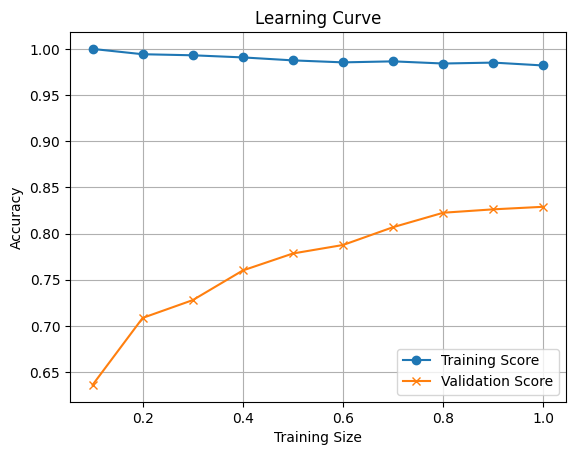

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_scores, test_scores = [], []
    for train_size in train_sizes:
        _, train_score, test_score = learning_curve(estimator, X, y, cv=cv, train_sizes=[train_size])
        train_scores.append(train_score.mean())
        test_scores.append(test_score.mean())
    plt.plot(train_sizes, train_scores, label='Training Score', marker='o')
    plt.plot(train_sizes, test_scores, label='Validation Score', marker='x')
    plt.title('Learning Curve')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

X_train, X_val, y_train, y_val = train_test_split(tfidf_matrix, df['sentiment'], test_size=0.2, random_state=24)
model = svm.SVC(C=10, kernel='rbf', gamma=1)

plot_learning_curve(model, X_train, y_train, cv=5)
plt.show()

In [87]:
joblib.dump(model, 'sentiment.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

### Find Best Parameters

In [52]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'tfidf__max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    'tfidf__min_df': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.01, 0.1, 1],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

In [53]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', svm.SVC())
])

In [54]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(df['processed_review'], df['sentiment'])

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10], 'svm__gamma': [0.01, 0.1, 1],
                         'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                         'tfidf__max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
                         'tfidf__min_df': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [55]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf', 'tfidf__max_df': 0.7, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Best cross-validation score:  0.7691119691119692


In [56]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'tfidf__max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    'tfidf__min_df': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': np.logspace(-2, 1, 4),
    'svm__gamma': np.logspace(-2, 1, 4),
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

In [57]:
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=2160, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(df['processed_review'], df['sentiment'])

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('svm', SVC())]),
                   n_iter=2160, n_jobs=-1,
                   param_distributions={'svm__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                                        'svm__gamma': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                                        'svm__kernel': ['linear', 'rbf', 'poly',
                                                        'sigmoid'],
                                        'tfidf__max_df': [0.7, 0.75, 0.8, 0.85,
                                                          0.9, 0.95],
                                        'tfidf__min_df': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)]},
                   random_state=42, verbose=2)

In [58]:
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

Best parameters found:  {'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 1, 'tfidf__max_df': 0.8, 'svm__kernel': 'rbf', 'svm__gamma': np.float64(1.0), 'svm__C': np.float64(10.0)}
Best cross-validation score:  0.7691119691119692
